In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [31]:
results = pd.read_csv('/content/results.csv')
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [32]:
races = pd.read_csv('/content/races.csv')
drivers = pd.read_csv('/content/drivers.csv')
constructors = pd.read_csv('/content/constructors.csv')
status = pd.read_csv('/content/status.csv')

In [33]:
print("results:", results.shape)
print("races:", races.shape)
print("drivers:", drivers.shape)
print("constructors:", constructors.shape)
print("status:", status.shape)

results: (26759, 18)
races: (1125, 18)
drivers: (861, 9)
constructors: (212, 5)
status: (139, 2)


In [34]:
for df,name in [(results,"results"),(races,"races"),(drivers,"drivers"),(constructors,"constructors"),(status,"status")]:
    print(name, df.columns.tolist()[:20])

# Ensure positions are numeric where possible
results['position'] = pd.to_numeric(results['position'], errors='coerce')

# Merge year into results for seasonal groupings
races_small = races[['raceId','year']].copy()
results = results.merge(races_small, on='raceId', how='left')

results ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId']
races ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']
drivers ['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']
constructors ['constructorId', 'constructorRef', 'name', 'nationality', 'url']
status ['statusId', 'status']


In [35]:
# Era-Adjusted Dominance
# Brief: For each season, compute driver_total_points / champion_total_points * 100, then average across seasons for each driver.
# Step A: season-driver total points
season_driver_points = results.groupby(['year','driverId'], dropna=False)['points'].sum().reset_index().rename(columns={'points':'driver_points'})

# Step B: champion points per season (max of driver_points)
champion_points = season_driver_points.groupby('year')['driver_points'].max().reset_index().rename(columns={'driver_points':'champion_points'})

season_driver_points = season_driver_points.merge(champion_points, on='year', how='left')
# Avoid division by zero; if champion_points is zero, mark ratio as 0
season_driver_points['era_ratio'] = np.where(
    season_driver_points['champion_points'] > 0,
    (season_driver_points['driver_points'] / season_driver_points['champion_points']) * 100,
    0
)

# Step C: average across seasons per driver
era_adjusted = season_driver_points.groupby('driverId')['era_ratio'].mean().reset_index().rename(columns={'era_ratio':'EraAdjustedDominance_raw'})

era_adjusted.head()

,driverId,EraAdjustedDominance_raw
0,1,81.228530
1,2,17.417409
2,3,45.112555
3,4,46.753997
4,5,14.930322


In [36]:
# Teammate Supremacy
# For each race & constructor, compare driver finishing positions vs teammates. Aggregate across career.

# Keep only relevant columns
res_tm = results[['raceId','constructorId','driverId','position','positionText','statusId','points','year']].copy()

# Determine finished flag using status.csv info
# status.csv often has columns statusId, status; mark finished for statusId in finished_ids or if position is numeric
finished_ids = set(status[status['status'].astype(str).str.lower().str.contains('finished', na=False)]['statusId'].astype(int).tolist())
if len(finished_ids) == 0:
    finished_ids = {1}
# Row-wise apply to avoid Series boolean error
res_tm['finished'] = res_tm.apply(
    lambda row: 1 if (pd.notna(row['statusId']) and int(row['statusId']) in finished_ids)
                or (pd.notna(row['position']))
                else 0,
    axis=1
)
# Treat NaN positions (DNF) as large number so they are considered behind finishers
res_tm['position_for_compare'] = res_tm['position'].fillna(999).astype(float)

# Function to compute teammate points per race+constructor
def teammate_points(group):
    pos = group[['driverId','position_for_compare']].set_index('driverId')['position_for_compare'].to_dict()
    driver_ids = list(pos.keys())
    out = []
    for d in driver_ids:
        ahead = sum(1 for other in driver_ids if pos[d] < pos[other])
        behind = sum(1 for other in driver_ids if pos[d] > pos[other])
        score = ahead - behind  # equal positions counted as 0
        out.append({'raceId': group['raceId'].iat[0], 'driverId': d, 'teammate_pair_score': score})
    return pd.DataFrame(out)

# Apply teammate_points function for each race+constructor
tm_points = res_tm.groupby(['raceId','constructorId'], group_keys=False).apply(teammate_points).reset_index(drop=True)

# Sum across career per driver
teammate_supremacy = tm_points.groupby('driverId')['teammate_pair_score'].sum().reset_index().rename(columns={'teammate_pair_score':'TeammateSupremacy_raw'})
# Show top rows
teammate_supremacy.head()


/tmp/ipython-input-3740715662.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tm_points = res_tm.groupby(['raceId','constructorId'], group_keys=False).apply(teammate_points).reset_index(drop=True)


,driverId,TeammateSupremacy_raw
0,1,75
1,2,25
2,3,20
3,4,148
4,5,5


In [37]:
# Adjusted Performance ('Giant Killer' Score)
# Brief: for each season rank constructors by season total points (1 best), then for each race compute CarRank - finishing position.
# Higher positive = overperforming relative to car.

# A: season-constructor total points
season_constructor_points = results.groupby(['year','constructorId'], dropna=False)['points'].sum().reset_index().rename(columns={'points':'constructor_points'})

# B: for each season rank constructors (1 best)
season_constructor_points['CarRank'] = season_constructor_points.groupby('year')['constructor_points'].rank(method='dense', ascending=False).astype(int)

# C: merge CarRank into results (on year + constructorId)
results = results.merge(season_constructor_points[['year','constructorId','CarRank']], on=['year','constructorId'], how='left')

# D: For each race row, compute performance = CarRank - finishing_position
# Use position (numeric); if position NaN (DNF) we will keep performance as CarRank - 999 -> large negative; later we may clip or leave as is.
results['fin_pos_for_car_adj'] = results['position'].fillna(999).astype(float)
results['CarAdj_individual'] = results['CarRank'] - results['fin_pos_for_car_adj']
# Sum across career per driver
car_adj = results.groupby('driverId')['CarAdj_individual'].sum().reset_index().rename(columns={'CarAdj_individual':'CarAdjustedPerformance_raw'})

car_adj.head()

,driverId,CarAdjustedPerformance_raw
0,1,-30515.0
1,2,-46090.0
2,3,-29255.0
3,4,-70229.0
4,5,-21313.0


In [38]:
# Consistency
# Brief: career finish rate = (total finished races / total started races) * 100
# Use earlier finished definition (status-based). If status is missing, infer from positionText if possible.

res_consist = results[['raceId','driverId','statusId','position','positionText']].copy()
# Use finished: statusId in finished_ids OR numeric position present
res_consist['finished_flag'] = np.where(
    res_consist['statusId'].notna() & res_consist['statusId'].apply(lambda x: int(x) in finished_ids if pd.notna(x) else False),
    1,
    np.where(res_consist['position'].notna(), 1, 0)
)

consistency = res_consist.groupby('driverId').agg(
    races_started = ('raceId','count'),
    races_finished = ('finished_flag','sum')
).reset_index()

consistency['Consistency_raw'] = (consistency['races_finished'] / consistency['races_started']).fillna(0) * 100
consistency_small = consistency[['driverId','Consistency_raw']]

consistency_small.head()

,driverId,Consistency_raw
0,1,91.573034
1,2,75.000000
2,3,85.922330
3,4,82.673267
4,5,81.250000


In [39]:
# Merge all raw metrics
# Brief: combine the four raw metrics into one DF; fill missing with 0.
metrics = drivers[['driverId','forename','surname','driverRef']].copy() if 'driverRef' in drivers.columns else drivers[['driverId','forename','surname']].copy()
metrics = metrics.merge(era_adjusted, on='driverId', how='left')
metrics = metrics.merge(teammate_supremacy, on='driverId', how='left')
metrics = metrics.merge(car_adj, on='driverId', how='left')
metrics = metrics.merge(consistency_small, on='driverId', how='left')

# Fill NaNs sensibly
metrics['EraAdjustedDominance_raw'] = metrics['EraAdjustedDominance_raw'].fillna(0)
metrics['TeammateSupremacy_raw'] = metrics['TeammateSupremacy_raw'].fillna(0)
metrics['CarAdjustedPerformance_raw'] = metrics['CarAdjustedPerformance_raw'].fillna(0)
metrics['Consistency_raw'] = metrics['Consistency_raw'].fillna(0)

metrics.head()

,driverId,forename,surname,driverRef,EraAdjustedDominance_raw,TeammateSupremacy_raw,CarAdjustedPerformance_raw,Consistency_raw
0,1,Lewis,Hamilton,hamilton,81.228530,75,-30515.0,91.573034
1,2,Nick,Heidfeld,heidfeld,17.417409,25,-46090.0,75.000000
2,3,Nico,Rosberg,rosberg,45.112555,20,-29255.0,85.922330
3,4,Fernando,Alonso,alonso,46.753997,148,-70229.0,82.673267
4,5,Heikki,Kovalainen,kovalainen,14.930322,5,-21313.0,81.250000


In [40]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0,100))
to_scale = ['EraAdjustedDominance_raw','TeammateSupremacy_raw','CarAdjustedPerformance_raw','Consistency_raw']
metrics_scaled = metrics.copy()

for col in to_scale:
    vals = metrics[[col]].values.astype(float)
    if np.nanmin(vals) == np.nanmax(vals):
        metrics_scaled[col.replace('_raw','_norm')] = 50.0
    else:
        metrics_scaled[col.replace('_raw','_norm')] = scaler.fit_transform(vals).reshape(-1)

In [41]:
# Compute final GOAT Score
metrics_scaled['GOAT_Score'] = (
    0.4 * metrics_scaled['EraAdjustedDominance_norm'] +
    0.3 * metrics_scaled['TeammateSupremacy_norm'] +
    0.2 * metrics_scaled['CarAdjustedPerformance_norm'] +
    0.1 * metrics_scaled['Consistency_norm']
)

# Rank drivers
metrics_scaled['GOAT_Rank'] = metrics_scaled['GOAT_Score'].rank(ascending=False, method='min').astype(int)

# Sort by rank
goat_ranking = metrics_scaled.sort_values('GOAT_Rank')[[
    'GOAT_Rank','driverId','forename','surname','GOAT_Score',
    'EraAdjustedDominance_norm','TeammateSupremacy_norm',
    'CarAdjustedPerformance_norm','Consistency_norm'
]]

# Show top 10
goat_ranking.head(10)

,GOAT_Rank,driverId,forename,surname,GOAT_Score,EraAdjustedDominance_norm,TeammateSupremacy_norm,CarAdjustedPerformance_norm,Consistency_norm
579,1,579,Juan,Fangio,92.626563,100.000000,90.047393,90.130693,75.862069
0,2,1,Lewis,Hamilton,83.400932,97.319512,65.402844,78.474852,91.573034
829,3,830,Max,Verstappen,80.726118,84.123311,75.829384,78.816924,85.645933
116,4,117,Alain,Prost,73.610409,97.300392,53.080569,58.434368,70.792079
29,5,30,Michael,Schumacher,73.544160,82.520212,73.933649,52.656524,78.246753
372,6,373,Jim,Clark,72.944468,68.955812,72.511848,83.796365,68.493151
3,7,4,Fernando,Alonso,70.766511,56.015739,100.000000,50.464442,82.673267
19,8,20,Sebastian,Vettel,70.230873,71.444228,61.137441,72.893083,87.333333
327,9,328,Jackie,Stewart,67.225858,82.270264,44.075829,73.975018,63.000000
642,10,642,Nino,Farina,66.212378,62.788096,50.710900,92.932862,72.972973


In [42]:
# Brief: GOAT Score = 0.4*Era + 0.3*Teammate + 0.2*CarAdj + 0.1*Consistency
weights = {'EraAdjustedDominance':0.4, 'TeammateSupremacy':0.3, 'CarAdjustedPerformance':0.2, 'Consistency':0.1}

metrics_scaled['GOAT_Score'] = (
    metrics_scaled['EraAdjustedDominance_norm'] * weights['EraAdjustedDominance'] +
    metrics_scaled['TeammateSupremacy_norm'] * weights['TeammateSupremacy'] +
    metrics_scaled['CarAdjustedPerformance_norm'] * weights['CarAdjustedPerformance'] +
    metrics_scaled['Consistency_norm'] * weights['Consistency']
)

# Add a full name column
metrics_scaled['driver_name'] = metrics_scaled['forename'].fillna('') + ' ' + metrics_scaled['surname'].fillna('')
metrics_scaled = metrics_scaled.sort_values('GOAT_Score', ascending=False).reset_index(drop=True)
# Top 20
top20 = metrics_scaled[['driverId','driver_name','GOAT_Score','EraAdjustedDominance_norm','TeammateSupremacy_norm','CarAdjustedPerformance_norm','Consistency_norm']].head(20)
top20.style.background_gradient(subset=['GOAT_Score'])


,driverId,driver_name,GOAT_Score,EraAdjustedDominance_norm,TeammateSupremacy_norm,CarAdjustedPerformance_norm,Consistency_norm
0,579,Juan Fangio,92.626563,100.000000,90.047393,90.130693,75.862069
1,1,Lewis Hamilton,83.400932,97.319512,65.402844,78.474852,91.573034
2,830,Max Verstappen,80.726118,84.123311,75.829384,78.816924,85.645933
3,117,Alain Prost,73.610409,97.300392,53.080569,58.434368,70.792079
4,30,Michael Schumacher,73.544160,82.520212,73.933649,52.656524,78.246753
5,373,Jim Clark,72.944468,68.955812,72.511848,83.796365,68.493151
6,4,Fernando Alonso,70.766511,56.015739,100.000000,50.464442,82.673267
7,20,Sebastian Vettel,70.230873,71.444228,61.137441,72.893083,87.333333
8,328,Jackie Stewart,67.225858,82.270264,44.075829,73.975018,63.000000
9,642,Nino Farina,66.212378,62.788096,50.710900,92.932862,72.972973


In [43]:
# Brief: save full results CSV and top20 CSV for download or further analysis
metrics_scaled.to_csv('goat_scores_all_drivers.csv', index=False)
top20.to_csv('goat_scores_top20.csv', index=False)
print("Saved goat_scores_all_drivers.csv and goat_scores_top20.csv in working directory.")

Saved goat_scores_all_drivers.csv and goat_scores_top20.csv in working directory.


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns # Also import seaborn since you're using 'sns'

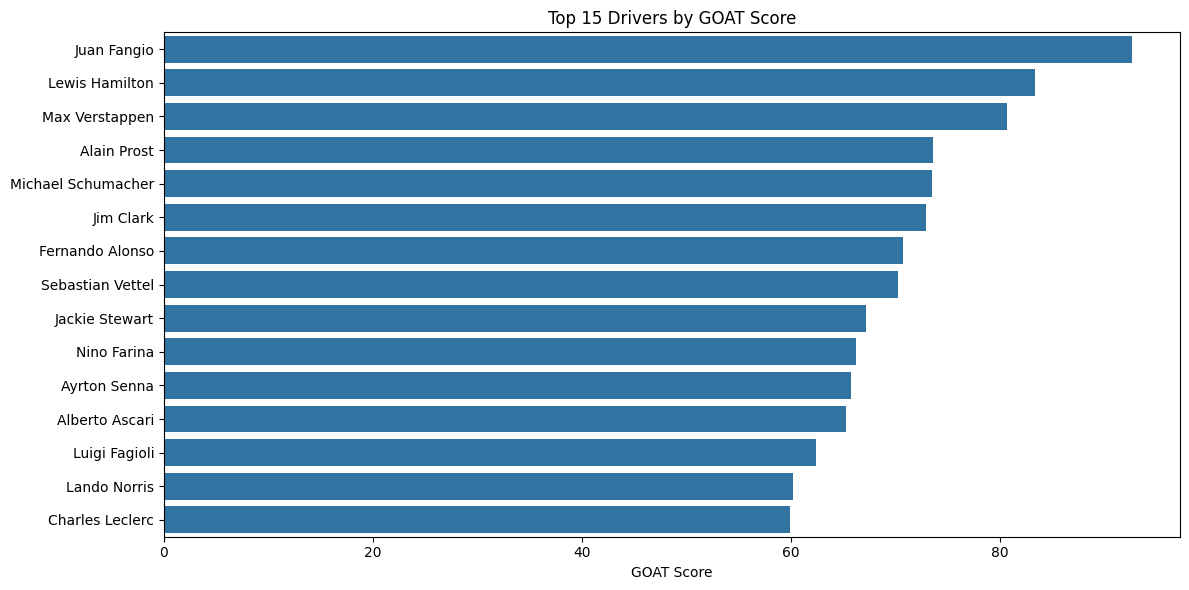

In [45]:
# Cell 12 - Visualizations: Bar chart of top 15 GOAT scores and metric breakdowns
# Brief: a few simple plots to show final rankings and metric contributions.
plt.figure(figsize=(12,6))
sns.barplot(data=top20.head(15), x='GOAT_Score', y='driver_name')
plt.title("Top 15 Drivers by GOAT Score")
plt.xlabel("GOAT Score")
plt.ylabel("")
plt.tight_layout()
plt.show()

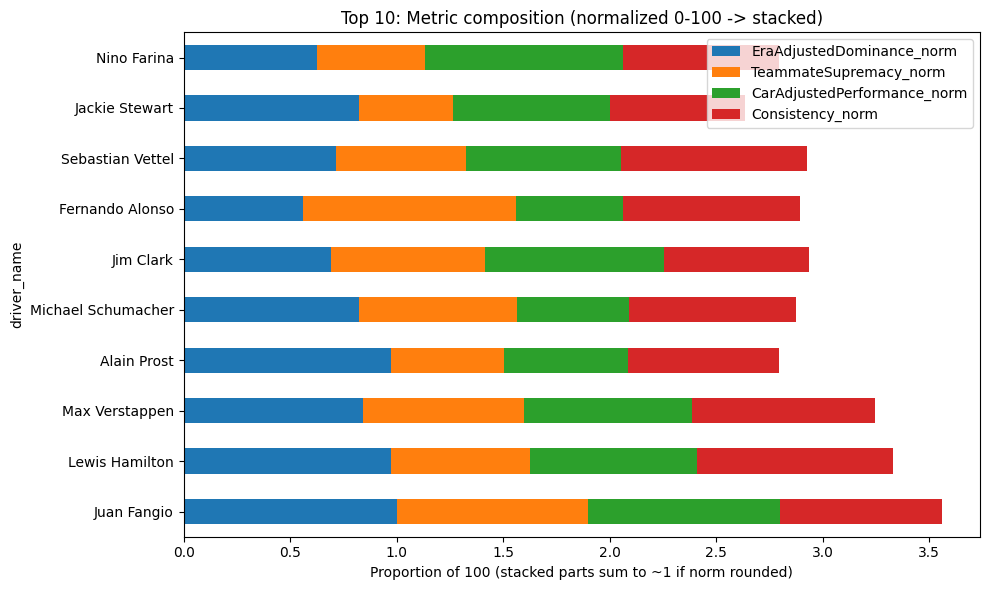

In [46]:
# Stacked bar of components for top 10 (normalized contribution)
top10 = metrics_scaled.head(10).copy()
comp_cols = ['EraAdjustedDominance_norm','TeammateSupremacy_norm','CarAdjustedPerformance_norm','Consistency_norm']
top10_plot = top10[['driver_name'] + comp_cols].set_index('driver_name')
top10_plot_norm = top10_plot.div(100)  # convert to 0-1 for stacking
top10_plot_norm.plot(kind='barh', stacked=True, figsize=(10,6))
plt.title("Top 10: Metric composition (normalized 0-100 -> stacked)")
plt.xlabel("Proportion of 100 (stacked parts sum to ~1 if norm rounded)")
plt.tight_layout()
plt.show()

In [47]:
# Cell 13 - Quick checks & caveats (print statements)
print("Number of drivers processed:", metrics_scaled.shape[0])
print("Columns in final dataframe:", metrics_scaled.columns.tolist())

# Show drivers with extreme raw values to sanity check
print("\nTop 5 by TeammateSupremacy_raw:")
print(metrics_scaled[['driver_name','TeammateSupremacy_raw']].sort_values('TeammateSupremacy_raw', ascending=False).head())

print("\nBottom 5 by CarAdjustedPerformance_raw:")
print(metrics_scaled[['driver_name','CarAdjustedPerformance_raw']].sort_values('CarAdjustedPerformance_raw').head())

Number of drivers processed: 861
Columns in final dataframe: ['driverId', 'forename', 'surname', 'driverRef', 'EraAdjustedDominance_raw', 'TeammateSupremacy_raw', 'CarAdjustedPerformance_raw', 'Consistency_raw', 'EraAdjustedDominance_norm', 'TeammateSupremacy_norm', 'CarAdjustedPerformance_norm', 'Consistency_norm', 'GOAT_Score', 'GOAT_Rank', 'driver_name']

Top 5 by TeammateSupremacy_raw:
           driver_name  TeammateSupremacy_raw
6      Fernando Alonso                    148
0          Juan Fangio                    127
15       Bruce McLaren                     99
2       Max Verstappen                     97
4   Michael Schumacher                     93

Bottom 5 by CarAdjustedPerformance_raw:
            driver_name  CarAdjustedPerformance_raw
860   Andrea de Cesaris                   -141779.0
846    Riccardo Patrese                   -130217.0
841    Michele Alboreto                   -112274.0
503  Rubens Barrichello                    -96937.0
834       Derek Warwick       